In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import models
import matplotlib.pyplot as plt

In [2]:
# ----------------------------
# 1. TIỀN XỬ LÝ ẢNH
# ----------------------------
def preprocess_image(path, target_size=96):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    img = cv2.resize(img, (256, 256))
    _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 50]
    if not contours:
        return None
    cnt = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(cnt)
    digit = binary[y:y+h, x:x+w]

    size_max = max(w, h)
    square = np.zeros((size_max, size_max), dtype=np.uint8)
    x_offset = (size_max - w) // 2
    y_offset = (size_max - h) // 2
    square[y_offset:y_offset+h, x_offset:x_offset+w] = digit

    resized = cv2.resize(square, (target_size, target_size), interpolation=cv2.INTER_AREA)
    normalized = resized.astype('float32') / 255.0
    normalized = normalized.reshape(target_size, target_size, 1)
    return np.expand_dims(normalized, axis=0)

In [3]:
# ----------------------------
# 2. CUSTOM DATASET
# ----------------------------
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, target_size=96):
        self.valid_data = []
        for path, label in zip(image_paths, labels):
            img = preprocess_image(path, target_size)
            if img is not None:
                self.valid_data.append((img, label))

    def __len__(self):
        return len(self.valid_data)

    def __getitem__(self, idx):
        img, label = self.valid_data[idx]
        img_tensor = torch.tensor(img, dtype=torch.float32).permute(0, 3, 1, 2).squeeze(0)
        return img_tensor, label

In [4]:
# ----------------------------
# 3. LOAD DỮ LIỆU
# ----------------------------
def load_image_paths_and_labels(root_dir):
    image_paths, labels = [], []
    for label in os.listdir(root_dir):
        label_path = os.path.join(root_dir, label)
        if not os.path.isdir(label_path):
            continue
        for filename in os.listdir(label_path):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(label_path, filename))
                labels.append(int(label))
    return image_paths, labels

In [5]:
# ----------------------------
# 4. HIỂN THỊ ẢNH MẪU
# ----------------------------
def show_first_n_images(dataset, n=5):
    plt.figure(figsize=(15, 3))
    for i in range(n):
        img_tensor, label = dataset[i]
        img_np = img_tensor.squeeze().numpy()
        plt.subplot(1, n, i+1)
        plt.imshow(img_np, cmap='gray')
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [6]:
# ----------------------------
# 5. TRAIN MODEL
# ----------------------------
def train(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Train loss: {total_loss / len(loader):.4f}")

In [7]:
# ----------------------------
# 6. TEST MODEL
# ----------------------------
def test(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    acc = 100 * correct / total
    print(f"Test loss: {total_loss / len(loader):.4f} - Accuracy: {acc:.2f}%")

In [8]:
# ----------------------------
# 7. DỰ ĐOÁN THƯ MỤC MỚI
# ----------------------------
def predict_digits_from_folder(model, input_folder, output_csv, device='cpu', target_size=96):
    model.eval()
    results = []
    for filename in sorted(os.listdir(input_folder)):
        if not filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue
        path = os.path.join(input_folder, filename)
        img = preprocess_image(path, target_size)
        if img is None:
            print(f"⚠️ Bỏ qua ảnh lỗi: {filename}")
            continue
        img_tensor = torch.tensor(img, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
        with torch.no_grad():
            output = model(img_tensor)
            pred = output.argmax(dim=1).item()
        results.append([filename, pred])
    pd.DataFrame(results, columns=["filename", "predicted_label"]).to_csv(output_csv, index=False)
    print(f"✅ Ghi kết quả vào: {output_csv}")

In [9]:
# ----------------------------
# 8. MAIN CHƯƠNG TRÌNH
# ----------------------------
def main():
    root_dir = r"C:\\Users\\ADMIN\\Desktop\\ML\\sort_images\\sort_images"
    INPUT_FOLDER = r"C:\\Users\\ADMIN\\Desktop\\ML\\data.2025"
    OUTPUT_CSV = r"C:\\Users\\ADMIN\\Desktop\\ML\\sub_resnet.csv"

    # Load và chia dữ liệu
    image_paths, labels = load_image_paths_and_labels(root_dir)
    x_train, x_test, y_train, y_test = train_test_split(image_paths, labels, test_size=0.1, stratify=labels, random_state=42)

    # Tạo Dataset
    train_dataset = CustomDataset(x_train, y_train, target_size=96)
    test_dataset = CustomDataset(x_test, y_test, target_size=96)

    # Hiển thị 5 ảnh đầu tiên sau khi custom
    show_first_n_images(train_dataset, n=5)

    # DataLoader
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64)

    # Model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    resnet18 = models.resnet18(weights=True)
    resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    resnet18.fc = nn.Linear(resnet18.fc.in_features, 10)
    model = resnet18.to(device)

    # Optimizer & Loss
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train và Test
    for epoch in range(1, 21):
        print(f"\nEpoch {epoch}")
        train(model, train_loader, criterion, optimizer, device)
        test(model, test_loader, criterion, device)

    # Dự đoán thư mục ảnh mới
    predict_digits_from_folder(model, INPUT_FOLDER, OUTPUT_CSV, device=device, target_size=96)

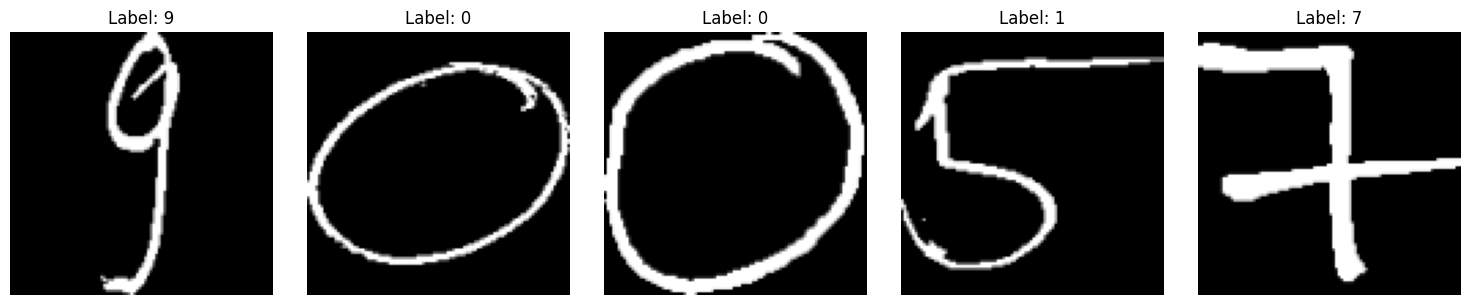

C:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1
Train loss: 1.2101
Test loss: 0.9454 - Accuracy: 70.03%

Epoch 2
Train loss: 0.7082
Test loss: 0.6160 - Accuracy: 79.82%

Epoch 3
Train loss: 0.5331
Test loss: 0.6219 - Accuracy: 80.71%

Epoch 4
Train loss: 0.4417
Test loss: 0.5713 - Accuracy: 83.09%

Epoch 5
Train loss: 0.3844
Test loss: 0.6649 - Accuracy: 82.34%

Epoch 6
Train loss: 0.3596
Test loss: 0.4296 - Accuracy: 85.31%

Epoch 7
Train loss: 0.3028
Test loss: 0.5584 - Accuracy: 81.75%

Epoch 8
Train loss: 0.2651
Test loss: 0.4652 - Accuracy: 85.76%

Epoch 9
Train loss: 0.2417
Test loss: 0.6900 - Accuracy: 81.16%

Epoch 10
Train loss: 0.2327
Test loss: 0.5333 - Accuracy: 84.42%

Epoch 11
Train loss: 0.1919
Test loss: 0.6394 - Accuracy: 83.68%

Epoch 12
Train loss: 0.1849
Test loss: 0.5696 - Accuracy: 85.61%

Epoch 13
Train loss: 0.1822
Test loss: 0.5899 - Accuracy: 85.01%

Epoch 14
Train loss: 0.1653
Test loss: 0.6122 - Accuracy: 85.31%

Epoch 15
Train loss: 0.1489
Test loss: 0.5679 - Accuracy: 84.87%

Epoch 16
Train los

In [10]:
# ----------------------------
# 9. CHẠY CHƯƠNG TRÌNH
# ----------------------------
if __name__ == "__main__":
    main()